Comprobar wavelet.

In [2]:
import sounddevice as sd
import pywt
import math
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pylab

In [3]:
N = 512
levels = 4
#wavelet_name = "haar"
#wavelet_name = "db5"
#wavelet_name = "db20"
wavelet_name = "bior2.2"
#wavelet_name = "rbio2.2"
#wavelet_name = "coif2"
#wavelet_name = "db3"
#wavelet_name = "sym2"
#wavelet_name = "sym4"
#wavelet_name = "bior4.4"
#wavelet_name = "bior4.5"
#wavelet_name = "rbio1.3"
wavelet = pywt.Wavelet(wavelet_name)
signal_mode_extension = "per"
quantization_step = 256
chunk_size = 128

RD Curves

In [4]:
fs = 44100      # Sampling frequency
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")

Say something!
done


In [86]:
def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int32)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def q_deq(x, quantization_step):
    k = quantizer(x, quantization_step)
    y = dequantizer(k, quantization_step)
    return k, y

def q_RD_curve(data):
    RD_points = []
    for q_step in range(16, 1024, 32):
        k, y = q_deq(data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        distortion = RMSE(data, y)
        RD_points.append((rate, distortion))
    return RD_points

def MST_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = x[:, 0].astype(np.int32) + x[:, 1] # L(ow frequency subband)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1] # H(igh frequency subband)
    return w

def MST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = (w[:, 0] + w[:, 1])/2 # L(ow frequency subband)
    x[:, 1] = (w[:, 0] - w[:, 1])/2 # H(igh frequency subband)
    return x

def MST_RD_curve(data):
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_data = MST_analyze(data)
        k, y = q_deq(analyzed_data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        reconstructed_data = MST_synthesize(y)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

def DWT_analyze(x, levels):
    coefs = np.empty(x.shape, dtype=np.int32)
    decomposition_0 = pywt.wavedec(x[:, 0], wavelet=wavelet, level=levels, mode="per")
    decomposition_1 = pywt.wavedec(x[:, 1], wavelet=wavelet, level=levels, mode="per")
    coefs_0, slices = pywt.coeffs_to_array(decomposition_0)
    coefs_1, slices = pywt.coeffs_to_array(decomposition_1)
    coefs[:, 0] = np.rint(coefs_0).astype(np.int32)
    coefs[:, 1] = np.rint(coefs_1).astype(np.int32)
    return coefs, slices

def DWT_synthesize(coefs, slices):
    samples = np.empty(coefs.shape, dtype=np.int16)
    decomposition_0 = pywt.array_to_coeffs(coefs[:, 0], slices, output_format="wavedec")
    decomposition_1 = pywt.array_to_coeffs(coefs[:, 1], slices, output_format="wavedec")
    samples[:, 0] = np.rint(pywt.waverec(decomposition_0, wavelet=wavelet, mode="per")).astype(np.int16)
    samples[:, 1] = np.rint(pywt.waverec(decomposition_1, wavelet=wavelet, mode="per")).astype(np.int16)
    return samples

def DWT_RD_curve(data, levels):
    RD_points = []
    for q_step in range(16, 1024, 32):
        MST_coefs = MST_analyze(data)
        DWT_coefs, slices = DWT_analyze(MST_coefs, levels)
        k, y = q_deq(DWT_coefs, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        MST_coefs = DWT_synthesize(y, slices)
        reconstructed_data = MST_synthesize(MST_coefs)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

def DWT_analyze_extended(x, levels):
    left_chunk = x[chunk_size * (chunk_number - 1) : chunk_size * chunk_number]
    center_chunk = x[chunk_size * chunk_number : chunk_size * (chunk_number + 1)]
    right_chunk = x[chunk_size * (chunk_number + 1) : chunk_size * (chunk_number + 2)]

    last_samples_left_chunk = left_chunk[chunk_size - number_of_overlaped_samples :]
    first_samples_right_chunk = right_chunk[: number_of_overlaped_samples]
    extended_chunk = np.concatenate([last_samples_left_chunk, center_chunk, first_samples_right_chunk])

    decomposition_0 = pywt.wavedec(extended_chunk[:,0], wavelet=wavelet, level=levels, mode="per")
    decomposition_1 = pywt.wavedec(extended_chunk[:,0], wavelet=wavelet, level=levels, mode="per")
    coefs = np.empty(extended_chunk.shape, dtype=np.int32)
    coefs_0, slices = pywt.coeffs_to_array(decomposition_0)
    coefs_1, slices = pywt.coeffs_to_array(decomposition_1)
    coefs[:, 0] = np.rint(coefs_0).astype(np.int32)
    coefs[:, 1] = np.rint(coefs_1).astype(np.int32)
    return coefs, slices

def DWT_synthesize_extended(coefs, slices):
    samples = np.empty(coefs.shape, dtype=np.int16)
    decomposition_0 = pywt.array_to_coeffs(coefs[:, 0], slices, output_format="wavedec")
    decomposition_1 = pywt.array_to_coeffs(coefs[:, 1], slices, output_format="wavedec")
    samples[:, 0] = np.rint(pywt.waverec(decomposition_0, wavelet=wavelet, mode="per")).astype(np.int16)
    samples[:, 1] = np.rint(pywt.waverec(decomposition_1, wavelet=wavelet, mode="per")).astype(np.int16)
    return samples

number_of_overlaped_samples = 1 << math.ceil(math.log(wavelet.dec_len * levels) / math.log(2))

def DWT_RD_curve_extended(data, levels):
    RD_points = []
    current_chunk = np.empty(data[:128].shape, dtype=np.int32)
    next_chunk = np.empty(data[:128].shape, dtype=np.int32)
    previous_chunk = np.empty(data[:128].shape, dtype=np.int32)
    extended_chunk = np.empty(data[:(128 + number_of_overlaped_samples * 2)].shape, dtype=np.int32)
    for i in range(0, 65536, chunk_size):
        chunk = data[i:(i + 128)]
        if i != 0:
            previous_chunk = current_chunk.copy()
            current_chunk = next_chunk.copy()
        
        next_chunk = chunk.copy()
        
        extended_chunk = np.concatenate([previous_chunk[-number_of_overlaped_samples :], current_chunk, next_chunk[: number_of_overlaped_samples]])
        
        #for q_step in range(16, 1024, 32):
        MST_coefs = MST_analyze(extended_chunk)
        DWT_coefs, slices = DWT_analyze(MST_coefs, levels)
        #k, y = q_deq(DWT_coefs, q_step)
        k, y = q_deq(DWT_coefs, 1)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        MST_coefs = DWT_synthesize(y, slices)
        reconstructed_chunk = MST_synthesize(MST_coefs)
        distortion = RMSE(extended_chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
    return RD_points

In [78]:
x = x[:65536]

In [87]:
q_RD_points = q_RD_curve(x)
MST_RD_points = MST_RD_curve(x)
DWT_RD_points = DWT_RD_curve(x, levels = 5)
DWT_RD_points_extended = DWT_RD_curve_extended(x, levels = 5)

EXTENDED:  [[          7           0]
 [          9           0]
 [          8           0]
 [          5           0]
 [          6           0]
 [          4           0]
 [          2           0]
 [          4           0]
 [          1           0]
 [          3           0]
 [          4           0]
 [          2           0]
 [          2           0]
 [          2           0]
 [          2           0]
 [          4           0]
 [          1           0]
 [          3           0]
 [          2           0]
 [          1           0]
 [          1           0]
 [          2           0]
 [          1           0]
 [          1           0]
 [          1           0]
 [          1           0]
 [          1           0]
 [         49           0]
 [ -475036224       32561]
 [         33           0]
 [  170847200       32562]
 [  170847200       32562]
 [-1451653808       21869]
 [          0           0]
 [          5           0]
 [          6           0]
 [          8    

 [   2    8]]
EXTENDED:  [[ 133  163]
 [ 329  309]
 [  29   30]
 [ 280  293]
 [ -53  -66]
 [ 118  114]
 [ 201  175]
 [ 297  310]
 [ 126  160]
 [  26   36]
 [  45   35]
 [ 181  173]
 [ 406  442]
 [ -19   -9]
 [  24   19]
 [   2   16]
 [ 210  178]
 [ 659  631]
 [ 159  171]
 [  95   99]
 [-198 -210]
 [ 102   94]
 [ 484  464]
 [ 421  463]
 [ 525  536]
 [-276 -253]
 [-184 -174]
 [ -39  -38]
 [ 451  409]
 [ 665  673]
 [ 256  278]
 [  65   75]
 [-472 -470]
 [ -49  -38]
 [ 317  292]
 [ 436  442]
 [ 239  268]
 [  37   18]
 [-172 -164]
 [  42   35]
 [ 141  142]
 [ 211  220]
 [ 384  427]
 [ 155  147]
 [  15   44]
 [-519 -509]
 [ 497  456]
 [ 398  396]
 [ 404  393]
 [  52   50]
 [-521 -564]
 [ 128  101]
 [ 253  255]
 [ 748  771]
 [ 183  217]
 [-192 -170]
 [-270 -263]
 [ 173  149]
 [ 325  355]
 [ 449  439]
 [ 167  213]
 [-352 -371]
 [ 234  239]
 [   3    8]
 [ 502  492]
 [ -45  -39]
 [-103 -113]
 [ -68  -57]
 [ 561  576]
 [ 310  357]
 [  17   26]
 [-260 -203]
 [-397 -419]
 [ 191  199]
 [ 159  186]


 [ -29  -45]]
EXTENDED:  [[   7  -20]
 [  45  -16]
 [ -41  -35]
 [ -21  -68]
 [  19  -60]
 [ -20  -53]
 [ -19   -9]
 [ -12  -43]
 [   4   16]
 [  -8  -13]
 [ -53  -72]
 [ -23  -19]
 [   2  -22]
 [ -55  -59]
 [ -36  -30]
 [ -83  -67]
 [ -35  -53]
 [ -60  -46]
 [ -41  -18]
 [  49   21]
 [ -38  -50]
 [ -13  -52]
 [ -11  -30]
 [ -47  -24]
 [ -63  -54]
 [ -79  -86]
 [-104  -85]
 [-127 -152]
 [ -19  -16]
 [ -99  -90]
 [ -65  -78]
 [-147 -129]
 [-113  -97]
 [-107 -122]
 [ -97 -121]
 [-111  -80]
 [ -96  -89]
 [-126 -104]
 [ -62  -74]
 [-118  -96]
 [ -50  -27]
 [ -49  -38]
 [-117 -155]
 [-137 -132]
 [-191 -178]
 [-143 -157]
 [ -93  -93]
 [ -74 -109]
 [ -83 -110]
 [-104  -86]
 [-148 -169]
 [-131 -117]
 [-115 -119]
 [ -73  -81]
 [-111 -104]
 [-104 -120]
 [-186 -178]
 [ -96 -109]
 [ -77 -111]
 [-110 -106]
 [ -44  -49]
 [ -69  -85]
 [-104 -101]
 [ -29  -45]
 [-117 -124]
 [ -93  -82]
 [ -60  -52]
 [-101  -95]
 [-123 -142]
 [-118 -115]
 [-127 -117]
 [ -93  -86]
 [ -53  -58]
 [ -48  -65]
 [-104 -122]


 [-120 -113]]
EXTENDED:  [[-121 -116]
 [-130 -124]
 [-155 -147]
 [-132 -143]
 [-106 -114]
 [ -97 -116]
 [-159 -169]
 [-137 -147]
 [-109 -117]
 [-193 -183]
 [-184 -179]
 [-172 -161]
 [-158 -155]
 [-175 -172]
 [-185 -185]
 [-150 -135]
 [-199 -200]
 [-151 -133]
 [-171 -148]
 [-174 -186]
 [-145 -159]
 [-184 -191]
 [-182 -172]
 [-226 -216]
 [-141 -135]
 [-205 -180]
 [-138 -155]
 [-148 -122]
 [-148 -147]
 [-202 -180]
 [-296 -287]
 [-163 -185]
 [-203 -206]
 [-120  -91]
 [-210 -173]
 [-272 -240]
 [-284 -260]
 [-200 -205]
 [-184 -170]
 [-240 -240]
 [-238 -262]
 [-199 -206]
 [-193 -191]
 [-202 -193]
 [-238 -202]
 [-165 -175]
 [-211 -189]
 [-134 -133]
 [-210 -179]
 [-193 -182]
 [-220 -212]
 [-169 -190]
 [-151 -105]
 [-191 -158]
 [-168 -216]
 [-193 -202]
 [-208 -164]
 [-222 -206]
 [-186 -163]
 [-183 -186]
 [-263 -279]
 [-226 -257]
 [-256 -255]
 [-120 -113]
 [-137 -134]
 [-146 -146]
 [-285 -261]
 [-300 -273]
 [-118  -96]
 [ -83  -45]
 [ -88  -64]
 [-238 -206]
 [-253 -249]
 [-243 -232]
 [-146 -120]


EXTENDED:  [[-479 -410]
 [-461 -437]
 [-527 -522]
 [-600 -590]
 [-616 -586]
 [-497 -519]
 [-464 -508]
 [-402 -439]
 [-552 -526]
 [-464 -484]
 [-593 -603]
 [-441 -433]
 [-460 -482]
 [-503 -496]
 [-495 -486]
 [-452 -492]
 [-509 -498]
 [-502 -453]
 [-474 -491]
 [-555 -540]
 [-534 -519]
 [-572 -582]
 [-511 -520]
 [-533 -526]
 [-472 -498]
 [-377 -410]
 [-535 -538]
 [-438 -453]
 [-562 -553]
 [-519 -510]
 [-469 -440]
 [-523 -480]
 [-527 -524]
 [-550 -560]
 [-496 -496]
 [-493 -522]
 [-400 -420]
 [-519 -526]
 [-480 -512]
 [-504 -488]
 [-469 -408]
 [-499 -507]
 [-509 -513]
 [-541 -521]
 [-540 -582]
 [-484 -527]
 [-591 -621]
 [-544 -565]
 [-582 -594]
 [-506 -524]
 [-553 -532]
 [-606 -580]
 [-560 -555]
 [-599 -628]
 [-550 -587]
 [-575 -545]
 [-550 -552]
 [-551 -541]
 [-517 -475]
 [-506 -485]
 [-518 -509]
 [-427 -483]
 [-513 -494]
 [-534 -517]
 [-463 -457]
 [-559 -529]
 [-470 -482]
 [-535 -524]
 [-456 -464]
 [-551 -589]
 [-497 -469]
 [-468 -481]
 [-508 -474]
 [-506 -523]
 [-537 -534]
 [-465 -471]
 

EXTENDED:  [[-281 -293]
 [-305 -331]
 [-254 -281]
 [-339 -332]
 [-268 -241]
 [-351 -337]
 [-337 -361]
 [-352 -347]
 [-349 -339]
 [-315 -303]
 [-347 -369]
 [-307 -310]
 [-281 -305]
 [-355 -372]
 [-361 -383]
 [-371 -369]
 [-290 -263]
 [-337 -316]
 [-364 -379]
 [-328 -298]
 [-415 -413]
 [-316 -321]
 [-303 -287]
 [-296 -312]
 [-285 -315]
 [-286 -305]
 [-267 -254]
 [-307 -312]
 [-274 -290]
 [-222 -217]
 [-273 -295]
 [-218 -270]
 [-314 -304]
 [-338 -355]
 [-230 -251]
 [-325 -310]
 [-309 -358]
 [-272 -262]
 [-322 -328]
 [-279 -313]
 [-345 -335]
 [-243 -282]
 [-321 -332]
 [-293 -299]
 [-212 -194]
 [-289 -280]
 [-222 -234]
 [-326 -313]
 [-214 -222]
 [-253 -261]
 [-259 -263]
 [-244 -246]
 [-298 -279]
 [-276 -272]
 [-301 -299]
 [-309 -322]
 [-217 -245]
 [-216 -251]
 [-271 -248]
 [-312 -307]
 [-218 -217]
 [-201 -199]
 [-251 -265]
 [-247 -281]
 [-297 -318]
 [-246 -281]
 [-154 -189]
 [-301 -251]
 [-235 -218]
 [-266 -265]
 [-393 -359]
 [-243 -260]
 [-224 -236]
 [-271 -285]
 [-281 -268]
 [-295 -287]
 

 [-107 -121]]
RECONSTRUCTED:  [[ 127   92]
 [  18  -30]
 [ -81  -91]
 [ 228  157]
 [ 279  282]
 [ 154  145]
 [ 134  151]
 [-117 -102]
 [ 167  162]
 [  92  107]
 [ 267  270]
 [ 159  156]
 [-156 -154]
 [  32   37]
 [  45   14]
 [ 293  287]
 [  74   49]
 [ 116   76]
 [ -86  -79]
 [-110 -117]
 [ 182  164]
 [ 195  202]
 [ 187  170]
 [-133 -109]
 [ -72 -124]
 [ 192  185]
 [ 232  214]
 [ 139  148]
 [ -75  -87]
 [ -13  -17]
 [ 131  114]
 [ 186  167]
 [ 113   78]
 [ -22   -8]
 [ -27   20]
 [ 165  160]
 [ 142  139]
 [  72   61]
 [ -31    6]
 [ -25   -6]
 [  91   87]
 [  73   63]
 [ -31  -53]
 [  87   67]
 [  50   29]
 [  66   71]
 [ -46  -90]
 [  30   35]
 [  70   65]
 [ 148  116]
 [ 295  251]
 [  75   77]
 [ -67  -68]
 [ -59  -80]
 [  74   63]
 [ 218  185]
 [ 274  245]
 [ 129  121]
 [  52   74]
 [ -47  -52]
 [ -88 -103]
 [ 145  127]
 [ 210  155]
 [ 204  168]
 [ 137  158]
 [ -50  -38]
 [ -77  -76]
 [  91   73]
 [  37   32]
 [ 157  163]
 [ 272  275]
 [ 112  110]
 [  52   65]
 [ -81 -104]
 [  37  

EXTENDED:  [[289 271]
 [383 344]
 [342 342]
 [307 326]
 [302 322]
 [266 283]
 [352 362]
 [246 281]
 [275 282]
 [201 193]
 [153 192]
 [359 363]
 [311 304]
 [297 327]
 [248 244]
 [163 191]
 [132 113]
 [156 155]
 [230 205]
 [362 355]
 [376 335]
 [311 326]
 [245 268]
 [255 211]
 [210 195]
 [218 234]
 [364 372]
 [315 303]
 [294 287]
 [324 314]
 [259 258]
 [233 226]
 [223 228]
 [240 210]
 [154 173]
 [258 285]
 [260 272]
 [294 298]
 [144 189]
 [224 200]
 [217 198]
 [220 239]
 [221 215]
 [177 200]
 [202 256]
 [232 238]
 [335 292]
 [345 327]
 [255 278]
 [177 193]
 [271 245]
 [164 177]
 [255 251]
 [346 346]
 [370 385]
 [261 259]
 [231 246]
 [190 219]
 [177 182]
 [199 227]
 [303 350]
 [100 113]
 [255 272]
 [182 188]
 [160 126]
 [210 191]
 [179 207]
 [228 238]
 [ 87  82]
 [190 173]
 [231 201]
 [298 266]
 [348 328]
 [206 230]
 [170 178]
 [136 155]
 [317 281]
 [296 281]
 [275 270]
 [220 215]
 [260 254]
 [134 134]
 [195 173]
 [288 298]
 [246 217]
 [281 299]
 [220 204]
 [233 224]
 [126 141]
 [198 202]

 [332 345]]
EXTENDED:  [[320 328]
 [354 372]
 [340 354]
 [373 351]
 [331 290]
 [345 386]
 [368 401]
 [390 365]
 [420 454]
 [284 298]
 [371 375]
 [315 351]
 [351 344]
 [403 367]
 [375 377]
 [378 385]
 [321 327]
 [387 391]
 [247 257]
 [436 422]
 [390 427]
 [312 318]
 [410 401]
 [322 297]
 [419 408]
 [338 404]
 [338 349]
 [331 310]
 [393 399]
 [443 431]
 [231 262]
 [301 301]
 [257 283]
 [329 322]
 [441 452]
 [363 376]
 [370 380]
 [265 275]
 [271 281]
 [324 339]
 [359 364]
 [359 392]
 [298 308]
 [220 243]
 [242 265]
 [227 232]
 [352 383]
 [390 377]
 [310 329]
 [262 286]
 [298 237]
 [382 366]
 [306 315]
 [354 338]
 [285 265]
 [385 380]
 [375 391]
 [360 389]
 [391 356]
 [356 364]
 [365 365]
 [348 309]
 [343 352]
 [332 345]
 [400 372]
 [332 346]
 [415 418]
 [395 366]
 [382 375]
 [425 409]
 [408 413]
 [465 496]
 [438 439]
 [448 467]
 [443 478]
 [412 443]
 [456 469]
 [488 524]
 [469 479]
 [421 437]
 [471 480]
 [493 467]
 [452 442]
 [522 551]
 [379 393]
 [477 443]
 [441 422]
 [471 461]
 [412 423

EXTENDED:  [[ 1253  1243]
 [ 1279  1303]
 [ 1283  1288]
 [ 1254  1267]
 [ 1306  1320]
 [ 1320  1338]
 [ 1256  1255]
 [ 1172  1156]
 [ 1181  1197]
 [ 1140  1168]
 [ 1064  1070]
 [  983   991]
 [  914   897]
 [  907   897]
 [  925   903]
 [  890   895]
 [  910   918]
 [  896   917]
 [  876   886]
 [  875   865]
 [  837   842]
 [  947   966]
 [ 1077  1076]
 [ 1122  1129]
 [ 1079  1106]
 [ 1101  1153]
 [ 1214  1210]
 [ 1247  1245]
 [ 1338  1318]
 [ 1229  1241]
 [ 1206  1209]
 [ 1094  1092]
 [ 1079  1054]
 [ 1098  1098]
 [ 1003  1003]
 [ 1048  1063]
 [  813   831]
 [  844   820]
 [  650   679]
 [  620   637]
 [  522   534]
 [  428   451]
 [  364   376]
 [  115   120]
 [  202   183]
 [   98   100]
 [  130    87]
 [   54    63]
 [  -89   -92]
 [ -177  -164]
 [ -163  -200]
 [ -184  -214]
 [ -268  -285]
 [ -174  -172]
 [ -308  -285]
 [ -321  -321]
 [ -341  -330]
 [ -383  -385]
 [ -369  -354]
 [ -397  -428]
 [ -507  -481]
 [ -592  -582]
 [ -621  -638]
 [ -663  -673]
 [ -644  -641]
 [ -793  -779]

 [ -510  -495]]
RECONSTRUCTED:  [[-2562 -2561]
 [-2495 -2483]
 [-2557 -2564]
 [-2354 -2383]
 [-2198 -2213]
 [-1899 -1879]
 [-1593 -1592]
 [-1266 -1309]
 [-1235 -1238]
 [-1008 -1035]
 [ -827  -831]
 [ -636  -629]
 [ -373  -390]
 [ -128  -160]
 [  -69   -91]
 [  -65   -96]
 [  107   103]
 [  368   368]
 [  502   478]
 [  515   514]
 [  516   539]
 [  584   575]
 [  702   697]
 [  755   770]
 [  886   865]
 [  845   801]
 [  936   907]
 [  957   926]
 [ 1006  1010]
 [ 1047  1016]
 [  997  1010]
 [  959   975]
 [  913   865]
 [  945   927]
 [  978   977]
 [ 1033  1012]
 [ 1044   985]
 [ 1087  1079]
 [ 1127  1102]
 [ 1148  1150]
 [ 1264  1225]
 [ 1242  1199]
 [ 1330  1329]
 [ 1367  1368]
 [ 1303  1306]
 [ 1317  1306]
 [ 1132  1143]
 [ 1102  1091]
 [ 1006   995]
 [ 1122  1110]
 [ 1062  1072]
 [  814   817]
 [  658   682]
 [  454   437]
 [  486   462]
 [  360   370]
 [  247   268]
 [   68    57]
 [  -96  -122]
 [ -219  -249]
 [ -257  -276]
 [ -292  -349]
 [ -463  -495]
 [ -555  -569]
 [ -572 

 [   95   133]]
RECONSTRUCTED:  [[ -349  -363]
 [ -465  -518]
 [ -533  -505]
 [ -509  -493]
 [ -508  -520]
 [ -594  -579]
 [ -590  -596]
 [ -675  -674]
 [ -612  -636]
 [ -622  -636]
 [ -575  -595]
 [ -588  -625]
 [ -704  -735]
 [ -697  -749]
 [ -740  -760]
 [ -773  -782]
 [ -692  -734]
 [ -772  -790]
 [ -659  -690]
 [ -749  -797]
 [ -740  -761]
 [ -718  -739]
 [ -775  -798]
 [ -795  -807]
 [ -795  -790]
 [ -749  -746]
 [ -707  -698]
 [ -689  -731]
 [ -643  -658]
 [ -640  -623]
 [ -740  -729]
 [ -717  -735]
 [ -664  -675]
 [ -563  -565]
 [ -394  -440]
 [ -343  -367]
 [ -178  -206]
 [ -213  -233]
 [ -183  -190]
 [ -197  -219]
 [ -129  -138]
 [  -16   -64]
 [  -30   -35]
 [  -47   -68]
 [  -60   -51]
 [  -73   -80]
 [  -15   -15]
 [    5     0]
 [   42    26]
 [   47    44]
 [   42    10]
 [  112   118]
 [  202   176]
 [  234   246]
 [  359   380]
 [  446   422]
 [  432   432]
 [  561   543]
 [  461   459]
 [  524   490]
 [  477   433]
 [  469   407]
 [  531   514]
 [  497   505]
 [  553 

 [ 128  110]]
EXTENDED:  [[ -66  -68]
 [ -37  -59]
 [ -34  -36]
 [ -55  -60]
 [ -62  -86]
 [ -36  -59]
 [ -29  -43]
 [ -43  -11]
 [-106  -69]
 [ -85  -75]
 [  46   26]
 [ -27  -10]
 [  12   23]
 [   0    7]
 [  66   91]
 [  61   65]
 [   3  -18]
 [  75  121]
 [  78   67]
 [  49   40]
 [  53   37]
 [  49   34]
 [ 115   89]
 [ 103   85]
 [ 104  132]
 [   7    9]
 [  94   78]
 [ 103   78]
 [  59   45]
 [  80   98]
 [  86  107]
 [  81   74]
 [  59   73]
 [ 134  107]
 [ 146  136]
 [  76   90]
 [ 140  123]
 [  66   77]
 [  65   62]
 [  47   17]
 [ 200  150]
 [ 227  242]
 [ 195  237]
 [ 156  151]
 [ 164  144]
 [ 207  183]
 [ 207  199]
 [ 223  210]
 [ 218  232]
 [  87   87]
 [ 182  170]
 [ 157  159]
 [ 177  135]
 [ 197  172]
 [ 159  167]
 [ 158  171]
 [ 167  143]
 [ 144  142]
 [ 164  182]
 [ 167  164]
 [ 102   72]
 [ 131  103]
 [ 118  121]
 [ 128  110]
 [ 139  135]
 [ 136  107]
 [  91  104]
 [ 127  104]
 [ 131  134]
 [  85  120]
 [ 188  184]
 [  38   74]
 [ 100  113]
 [ 133  130]
 [ 260  245]


 [  -5   33]]
EXTENDED:  [[  99  114]
 [  24    9]
 [ -63 -103]
 [ -24  -32]
 [ -48  -34]
 [  72   58]
 [  16    0]
 [ -39  -32]
 [   9  -22]
 [ -54  -40]
 [  70   44]
 [ -15  -33]
 [  54   33]
 [ -15  -22]
 [ -44  -45]
 [  46   22]
 [   2   30]
 [  71  107]
 [  30   51]
 [  15   31]
 [ -91  -95]
 [  -6    2]
 [ -43   -6]
 [ -44  -16]
 [  -9   26]
 [ -18   -8]
 [   5  -29]
 [ -68 -101]
 [  34   60]
 [  -8   35]
 [  17   16]
 [ -23  -39]
 [  -8  -33]
 [ -46  -29]
 [   9   35]
 [  61   47]
 [ -19   -8]
 [  12  -22]
 [ -21  -18]
 [  79   66]
 [  36   62]
 [   8    3]
 [  58   31]
 [ -40  -57]
 [  93   82]
 [  -5    4]
 [  96   81]
 [  21   40]
 [ -50  -62]
 [  62   46]
 [ -72  -88]
 [  40   25]
 [  39   49]
 [  32   53]
 [ -55  -31]
 [ -52  -27]
 [   8   -2]
 [  94   88]
 [  66   56]
 [  52   22]
 [  24   11]
 [ -39  -49]
 [  37   68]
 [  -5   33]
 [ 131  141]
 [ -31   -7]
 [ -81  -81]
 [ -68  -71]
 [  16   28]
 [  23   28]
 [ -67  -68]
 [ -16   14]
 [ -50  -55]
 [ -73  -69]
 [ -35   -8]


EXTENDED:  [[-118 -152]
 [-138 -127]
 [-127 -135]
 [-180 -175]
 [-220 -231]
 [-176 -163]
 [-144 -119]
 [ -73  -73]
 [-169 -135]
 [-134 -117]
 [-193 -169]
 [ -86  -63]
 [ -52  -72]
 [ -85  -96]
 [ -94  -63]
 [-210 -175]
 [-147 -146]
 [-222 -218]
 [-133 -124]
 [-164 -134]
 [-141 -137]
 [-158 -144]
 [-166 -160]
 [-172 -163]
 [ -26  -15]
 [-127  -85]
 [-162 -146]
 [-121 -119]
 [ -74 -100]
 [-168 -168]
 [ -62  -57]
 [-140 -130]
 [-187 -158]
 [-138 -105]
 [-122 -143]
 [-147 -117]
 [-180 -194]
 [-115 -126]
 [ -67  -87]
 [ -44  -18]
 [ -60  -37]
 [ -29  -59]
 [-154 -151]
 [ -95 -124]
 [ -46  -46]
 [-165 -179]
 [ -38  -38]
 [-164 -180]
 [ -58  -55]
 [ -95  -92]
 [ -61  -47]
 [ -35  -25]
 [ -68  -69]
 [-105  -67]
 [-168 -136]
 [  22    3]
 [  28   23]
 [ -81  -60]
 [-123 -114]
 [-124 -115]
 [ -88  -76]
 [-114 -101]
 [ -83  -34]
 [-118 -119]
 [ -83  -29]
 [-146  -91]
 [ -54  -29]
 [-129  -90]
 [-138 -120]
 [-104  -85]
 [-108 -143]
 [ -77  -44]
 [-138 -156]
 [-172 -160]
 [-123 -103]
 [-162 -188]
 

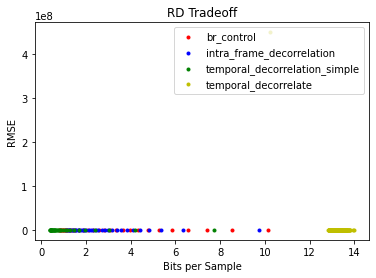

In [73]:
plt.title("RD Tradeoff")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
plt.scatter(*zip(*q_RD_points), c='r', marker=".", label='br_control')
plt.scatter(*zip(*MST_RD_points), c='b', marker=".", label='intra_frame_decorrelation')
plt.scatter(*zip(*DWT_RD_points), c='g', marker=".", label='temporal_decorrelation_simple')
plt.scatter(*zip(*DWT_RD_points_extended), c='y', marker=".", label='temporal_decorrelate')
plt.legend(loc='upper right')
plt.show()

In [ ]:
!python ./br_control.py --show_stats

In [ ]:
!python ./intra_frame_decorrelation.py --show_stats

In [ ]:
!python ./temporal_decorrelation_simple.py --show_stats

In [ ]:
!python ./temporal_decorrelate.py --show_stats